In [30]:
%reset -f

In [31]:
from PIL import Image
import cv2
from fenceBuilder import checkInside, fenceBuild, drawFence
%matplotlib inline
import matplotlib
from matplotlib import pyplot as plt
import torch
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.transforms import functional as F
import numpy as np

In [32]:
# Load the model pre-trained on COCO dataset
model = fasterrcnn_resnet50_fpn(pretrained=True)

# Set the model to evaluation mode
model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [33]:
# img_path = "Images\\exported frames\\day_frame_960.jpg"
img_path = "D:\\Documents\\NU\\sem_6\\NU 302 R&D Project\\Fencing Results\\Data\\Near\\i19.jpg"
image = cv2.imread(img_path)
image_tensor = F.to_tensor(image)

In [34]:
fenceBuild(image)

imageClose True


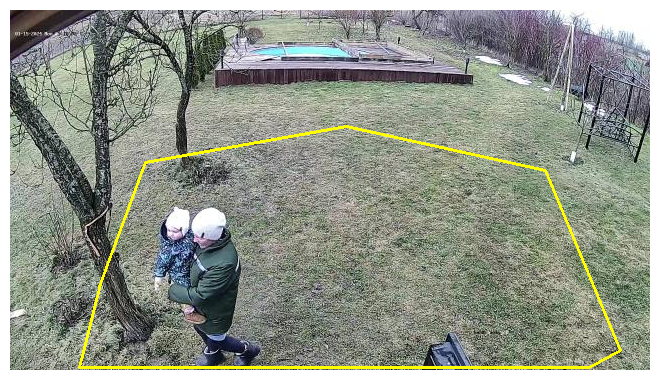

In [35]:
# draw fence over the frame
drawFence(image)
dpi = matplotlib.rcParams['figure.dpi']
height, width, depth = image.shape

figsize = width / float(dpi), height / float(dpi)

fig = plt.figure(figsize=figsize)
fig.add_axes([0, 0, 1, 1])
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

INSIDE


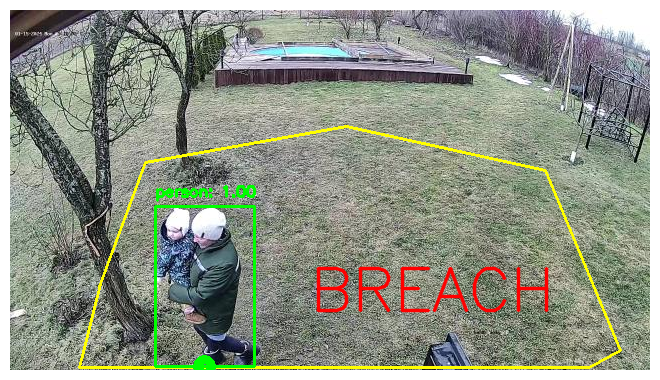

In [36]:
# Perform object detection
with torch.no_grad():
    results = model([image_tensor])

# Extract bounding boxes, labels, and scores
boxes = results[0]['boxes'].tolist()  # Bounding box coordinates
scores = results[0]['scores'].tolist()  # Confidence scores
labels = results[0]['labels'].tolist()  # Class labels


# Threshold parameters
confidence_threshold = 0.5  # Set confidence threshold for filtering boxes
iou_threshold = 0.7  # IOU threshold for NMS (you may want to implement NMS yourself if needed)


outcome = False
for i, box in enumerate(boxes):
    # Only consider boxes with high confidence
    if scores[i] >= confidence_threshold and labels[i] == 1:  # Class ID 1 represents person object
        x_min, y_min, x_max, y_max = box
        center_x = int((x_min + x_max) / 2)
        center_y = int(y_max)  # Calculating the bottom center (feet) of the bounding box
        
        cv2.rectangle(image, (int(x_min), int(y_min)), (int(x_max), int(y_max)), (0, 255, 0), 2)
        label = f'person: {scores[i]:.2f}'  # Format the score to 2 decimal places
            
        # Add the label above the bounding box
        cv2.putText(image, label, (int(x_min), int(y_min) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
        
        # Visualize the center of the bounding box
        cv2.circle(image, (center_x, center_y), 7, (0, 255, 0), 8)

        # Check whether centroid is inside the fence
        if not outcome:
            outcome = checkInside(center_x, center_y)

# Annotate the image with breach or no breach
if outcome:
    cv2.putText(image, 'BREACH', (300, 300), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 0, 255), 2, cv2.LINE_AA)
else:
    cv2.putText(image, 'NO BREACH', (300, 300), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 255, 0), 2, cv2.LINE_AA)

# Display the annotated frame using matplotlib
dpi = plt.rcParams['figure.dpi']
height, width, _ = image.shape
figsize = width / float(dpi), height / float(dpi)

fig = plt.figure(figsize=figsize)
fig.add_axes([0, 0, 1, 1])
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()